# <font color = '#00CCFF'> High Value Customer Identification </font>

Project Objective: Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups:

Dataset Description: This is a transnational dataset that contains all the transactions occurring between Nov-2016 to Dec-2017 for a UK-based online retail store.

Attribute Description:
- InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode: Product (item) code
- Description: Product (item) name
- Quantity: The quantities of each product (item) per transaction
- InvoiceDate: The day when each transaction was generated
- UnitPrice: Unit price (Product price per unit)
- CustomerID: Customer number (Unique ID assigned to each customer)
- Country: Country name (The name of the country where each customer resides)

### Output:

1. A indicação de pessoal para fazer parte do programa de "INSIDEERS"
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição dos inseiders no faturamento?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao grupo?
    - Quais as condições para uma pessoa ser removida do grupo?
    - Qual a garantia que o programa é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import scikitplot as skplt
#import plotly.express as px

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy

import umap.umap_ as umap

import sqlite3
from sqlalchemy import create_engine

## 0.2. Functions

## 0.3. Load dataset

In [2]:
path = '/home/ezequiel/Documentos/Comunidade_DS/insiders_clustering/data/raw/Ecommerce.zip'
df_raw = pd.read_csv(path, encoding='unicode_escape', compression='zip')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1. Descrição dos dados

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [4]:
cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

## 1.2. Data dimensions

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

InvoiceNo should be a number, but some records have letters

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [8]:
# Procurar se há algum customer_id "perdido" a partir do invoice_no
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

In [9]:
df_not_missing.shape

(406829, 8)

In [10]:
#missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

In [11]:
# Alternativa: atribuir um customer_id não utilizado para cada invoice_no único que não possui customer_id
aux = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
aux['customer_id'] = np.arange(19000, 19000+len(aux), 1)

df1 = pd.merge(df1, aux, on='invoice_no', how='left')
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [13]:
#df1 = df1.dropna(subset=['description', 'customer_id'])

## 1.6. Change dtyper

In [14]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [15]:
# invoice_date -> to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id -> to int
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7. Descriptive statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include='object')

### 1.7.1. Numerical attributes

In [17]:
df_describe = num_attributes.describe().T
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['median'] = num_attributes.median()
df_describe['skewness'] = num_attributes.skew()
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe.reset_index()

,index,count,mean,std,min,25%,50%,75%,max,range,median,skewness,kurtosis
0,quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,161990.00,3.00,-0.264076,119769.160031
1,unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,50032.06,2.08,186.506972,59005.719097
2,customer_id,541909.0,16688.840453,2911.411352,12346.00,14367.00,16249.00,18283.00,22709.0,10363.00,16249.00,0.487449,-0.804287


### 1.7.2. Categorical attributes

#### Invoice_no

In [18]:
# verifica se invoice_no contém, ao menos, uma letra e agrupa por invoice_no para o dataframe inteiro
aux = df1[df1['invoice_no'].str.contains('[a-zA-Z]')].groupby('invoice_no').count().reset_index()
print(f'Qtd de invoices únicos com letras: {len(aux)}')
print(f'Qtd total de invoices com letras {aux["stock_code"].sum()}')

Qtd de invoices únicos com letras: 3839
Qtd total de invoices com letras 9291


In [19]:
aux = df1.loc[df1['invoice_no'].str.contains('[a-zA-Z]')].query('quantity < 0').shape[0]
print(f'Qtd de invoices com letras onde a quantidade é negativa: {aux}')

Qtd de invoices com letras onde a quantidade é negativa: 9288


#### Stock_code

In [20]:
# verifica se stock_code contém, ao menos, uma letra e conta quantos são
df1[df1['stock_code'].str.contains('[a-zA-Z]')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2017-12-07,4.15,Germany,12713
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2017-12-07,1.79,United Kingdom,17581
541838,581580,84993A,75 GREEN PETIT FOUR CASES,2,2017-12-07,0.42,United Kingdom,12748
541844,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2017-12-07,1.25,United Kingdom,12748


In [21]:
# verifica se stock_code contém somente letras e mostra a quantidade de ocorrências
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].value_counts()

stock_code
POST            1256
DOT              710
M                571
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
PADS               4
B                  3
m                  1
Name: count, dtype: int64

In [22]:
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm',
       'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [23]:
df1['country'].value_counts(normalize=True)

country
United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
Eu

# 2. Variables Filtering

In [24]:
df2 = df1.copy()

In [25]:
# selecionar somente preços maiores que 4 centavo
df2 = df2.query('unit_price >= 0.04')

In [26]:
# retirar alguns stock_codes
codes = ['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
#codes = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2.query('stock_code != @codes')

In [27]:
df2 = df2.drop(columns='description')

In [28]:
drop_country = ['European Community', 'Unspecified']
df2 = df2.query('country != @drop_country')

In [29]:
# Bad users
bad_users = [16446]
df2 = df2.query('customer_id != @bad_users')

In [30]:
# separar as quantidades negativas como devoluções (cancelamentos)
df2_returns = df2.query('quantity < 0')
df2_purchases = df2.query('quantity >= 0')

# 3. Feature Engineering

In [31]:
df3 = df2.copy()

In [32]:
# data reference - group by customer
#df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [33]:
df_ref.shape

(5761, 1)

#### **Gross revenue (Faturamento)**

Faturamento para cada produto = quantidade x preço

In [34]:
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

/tmp/ipykernel_47145/1787153609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


In [35]:
# total value of purchases per customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

In [36]:
df_ref.isna().sum()

customer_id       0
gross_revenue    67
dtype: int64

#### **Recency**

How recent is the last purchase made by each customer.

In [37]:
# find the last purchase date of each customer and subtracts of the overall last purchase date
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency          67
dtype: int64

#### **Quantity of products purchased**

In [38]:
aux = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtd_products'})
df_ref = pd.merge(df_ref, aux, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency          67
qtd_products     67
dtype: int64

#### **Frequency purchase**

In [39]:
df_aux = df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                            max_inv_date = ('invoice_date', max),
                                                            min_inv_date = ('invoice_date', min),
                                                            days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                                            buy_ = ('invoice_no', 'count')).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency          67
qtd_products     67
frequency        67
dtype: int64

#### **Number of returns**

In [40]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'returns'})
df_returns['returns'] = df_returns['returns'] * -1

In [41]:
df_ref= pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

In [42]:
#df_ref.drop(columns=['invoice_date'], inplace=True)

In [43]:
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency          67
qtd_products     67
frequency        67
returns           0
dtype: int64

In [44]:
## Average recency days
#df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
#df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
#df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date
#
#df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )
#
#df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()
#
## average recency 
#df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()
#
## merge
#df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
#df_ref.isna().sum()

# 4. EDA (Exploratory Data Analysis)

In [45]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency          0
qtd_products     0
frequency        0
returns          0
dtype: int64

## 4.3. Estudo do Espaço

In [46]:
cols_selected = ['customer_id', 'gross_revenue', 'recency', 'qtd_products', 'frequency', 'returns']
df43 = df4[cols_selected].drop(columns='customer_id').copy()

In [47]:
df43.columns

Index(['gross_revenue', 'recency', 'qtd_products', 'frequency', 'returns'], dtype='object')

In [48]:
mm = MinMaxScaler()

In [49]:
df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency'] = mm.fit_transform(df43[['recency']])
df43['qtd_products'] = mm.fit_transform(df43[['qtd_products']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['returns'] = mm.fit_transform(df43[['returns']])

In [50]:
X = df43.copy()

### 4.3.2. UMAP

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

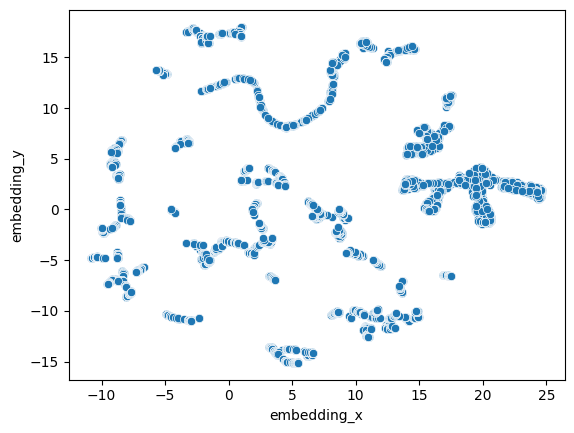

In [51]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_umap)

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

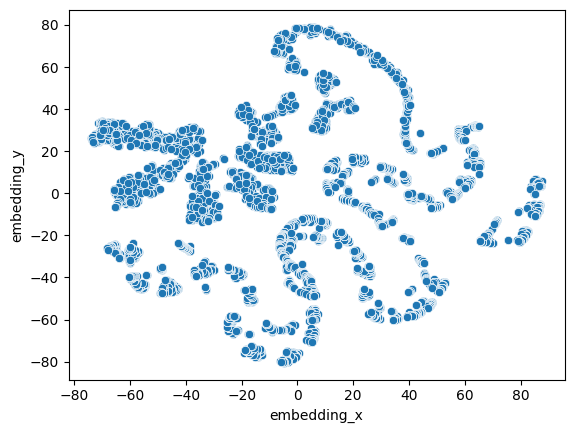

In [52]:
reducer = TSNE(n_components=2, n_jobs = -1, random_state=42)
embedding = reducer.fit_transform(X)

df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tsne)

### 4.3.4. Tree-Based Embedding

In [53]:
#X = df4.drop(columns=['customer_id','gross_revenue'])
#y = df4['gross_revenue']

X = df43.drop(columns='gross_revenue', axis=1)
y = df43['gross_revenue']

In [54]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)

df_leaf = pd.DataFrame(rf_model.apply(X))
# Retorna uma tabela onde as colunas representam uma árvore e as linhas, cada customer.
# O Valor retornado é o índice da folha que aquele customer se encontra, naquela árvore indicada pela coluna

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

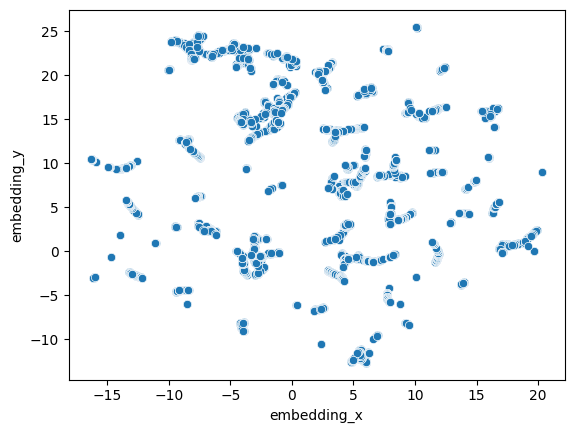

In [55]:
# Redução de dimensionalidade
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree)

# 5. Data Preparation

**Dica:**

Rescale vs. Standardization
1. Se os dados possuem distribuição normal e não possui outlier -> Standard scaler
2. Se os dados possuem distribuição normal e possui outlier -> Robust scaler
3. Se os dados não possuem distribuição normal -> MinMax scaler

Rescale --> $\frac{Valor - min(Valor)}{max(Valor) - min(Valor)}$ --> Adimensional
 
Standardization --> $\frac{Valor - média(Valor)}{desvioPadrao(Valor)}$ --> Adimensional

**Testes de Normalização:**

* QQ Plot - Quantile Quantile Plot (quantil teorico vs. quantil real)
* KS Test - Kolgomorov Smirnoff (teste de hipóteses):
    * p-value > 0.5, distribuição normal
    * p-value < 0.5, distribuição não normal

**Detecção de Outliers:**
* Boxplot --> pontos são identificados como outliers
* Pontos acima da distância interquartil X 2,5 --> outliers
* Z-score > 3 ou Z-score < -3 --> outliers

In [56]:
# Tree-based embedding
df5 = df_tree.copy()

## UMAP embedding
#df5 = df_umap.copy()
#
## T-SNE embedding
#df5 = df_tsne.copy()

# 7. Hyperparameter Fine Tunning

In [57]:
X = df5.copy()

In [58]:
clusters = np.arange(2, 25, 1)

## 7.1. K-Means

In [59]:
kmeans_list = []

for k in clusters:
    kmeans_model = KMeans(n_clusters=k, n_init=100, random_state=42)

    kmeans_model.fit(X)

    labels = kmeans_model.predict(X)

    SS = silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(SS)

Text(0.5, 1.0, 'Silhouette Score vs. k')

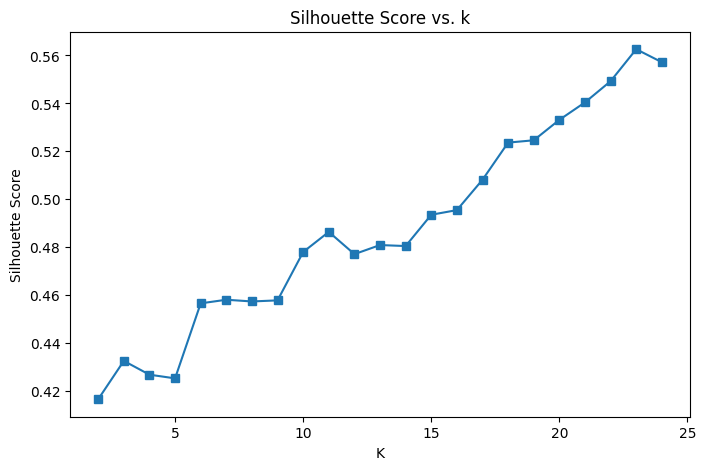

In [60]:
plt.figure(figsize=(8,5))
plt.plot(clusters, kmeans_list, marker='s')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

## 7.2. GMM

In [61]:
gmm_list = []

for k in clusters:
    gmm_model = GaussianMixture(n_components=k, n_init=10, random_state=42)

    gmm_model.fit(X)

    labels = gmm_model.predict(X)

    SS = silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(SS)

Text(0.5, 1.0, 'Silhouette Score vs. k')

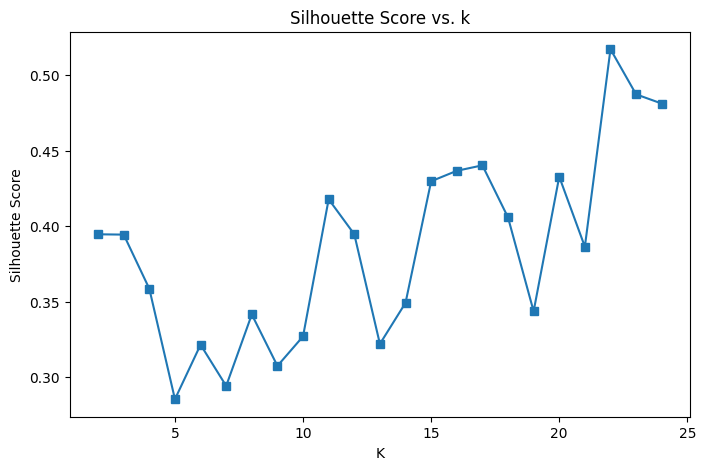

In [62]:
plt.figure(figsize=(8,5))
plt.plot(clusters, gmm_list, marker='s')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

## 7.3. Hierarchical Clustering

In [63]:
hc_model = hierarchy.linkage(X, 'ward')

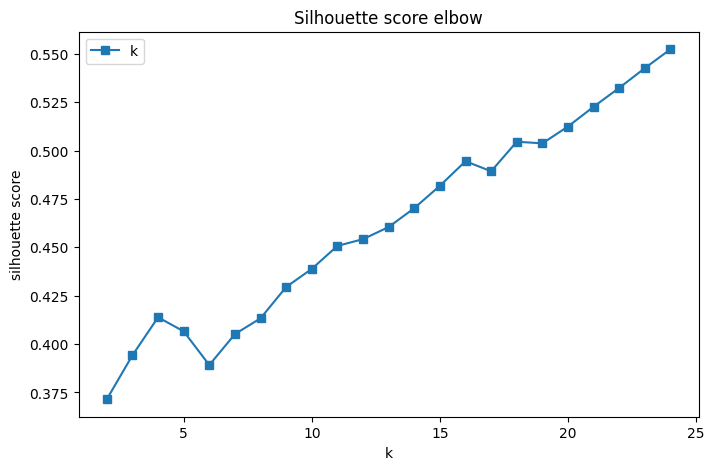

In [64]:
hc_list = []

for k in clusters:
    labels = hierarchy.fcluster(hc_model, t=k, criterion='maxclust')
    ss = silhouette_score(X, labels=labels, metric='euclidean')
    hc_list.append(ss)

plt.figure(figsize=(8,5))
plt.plot(clusters, hc_list, marker='s')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette score elbow')
plt.legend('k')

## 7.4. Results

### 7.4.1. Tree-based Embedding

In [65]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'H-clustering': hc_list},
    index=clusters
).T

df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.416546,0.432536,0.426784,0.425248,0.456554,0.458062,0.457345,0.457796,0.477980,0.486373,0.477093,0.480880,0.480466,0.493530,0.495462,0.508135,0.523642,0.524599,0.533134,0.540423,0.549272,0.562604,0.557187
GMM,0.394567,0.394350,0.358542,0.285432,0.321502,0.294218,0.341520,0.307472,0.327018,0.417744,0.394606,0.322021,0.349204,0.429660,0.436566,0.440195,0.405757,0.343599,0.432681,0.386334,0.517030,0.487171,0.481078
H-clustering,0.371477,0.394195,0.413830,0.406544,0.389159,0.405137,0.413312,0.429491,0.438846,0.450721,0.454216,0.460476,0.470232,0.481804,0.494491,0.489294,0.504559,0.503736,0.512429,0.522659,0.532398,0.542600,0.552380


### 7.4.1. UMAP Embedding

In [66]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'H-clustering': hc_list},
    index=clusters
).T

df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.416546,0.432536,0.426784,0.425248,0.456554,0.458062,0.457345,0.457796,0.477980,0.486373,0.477093,0.480880,0.480466,0.493530,0.495462,0.508135,0.523642,0.524599,0.533134,0.540423,0.549272,0.562604,0.557187
GMM,0.394567,0.394350,0.358542,0.285432,0.321502,0.294218,0.341520,0.307472,0.327018,0.417744,0.394606,0.322021,0.349204,0.429660,0.436566,0.440195,0.405757,0.343599,0.432681,0.386334,0.517030,0.487171,0.481078
H-clustering,0.371477,0.394195,0.413830,0.406544,0.389159,0.405137,0.413312,0.429491,0.438846,0.450721,0.454216,0.460476,0.470232,0.481804,0.494491,0.489294,0.504559,0.503736,0.512429,0.522659,0.532398,0.542600,0.552380


### 7.4.1. t-SNE Embedding

In [67]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'H-clustering': hc_list},
    index=clusters
).T

df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.416546,0.432536,0.426784,0.425248,0.456554,0.458062,0.457345,0.457796,0.477980,0.486373,0.477093,0.480880,0.480466,0.493530,0.495462,0.508135,0.523642,0.524599,0.533134,0.540423,0.549272,0.562604,0.557187
GMM,0.394567,0.394350,0.358542,0.285432,0.321502,0.294218,0.341520,0.307472,0.327018,0.417744,0.394606,0.322021,0.349204,0.429660,0.436566,0.440195,0.405757,0.343599,0.432681,0.386334,0.517030,0.487171,0.481078
H-clustering,0.371477,0.394195,0.413830,0.406544,0.389159,0.405137,0.413312,0.429491,0.438846,0.450721,0.454216,0.460476,0.470232,0.481804,0.494491,0.489294,0.504559,0.503736,0.512429,0.522659,0.532398,0.542600,0.552380


# 8. Model Training

## 8.1. Final model - GMM

In [68]:
k = 8
gmm_model = GaussianMixture(n_components=k, n_init=300, random_state=32)
gmm_model.fit(X)
labels = gmm_model.predict(X)

## 8.2. Cluster Validation

In [69]:
print(f'SS value: {silhouette_score(X, labels=labels, metric="euclidean")}')

SS value: 0.30077624320983887


# 9. Cluster Analisys

In [70]:
df9 = X.copy()
#df9 = df7.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,-6.068001,22.610088,7
1,-4.103973,23.126780,7
2,-5.192372,22.915712,7
3,-6.756420,2.629829,4
4,-1.177031,-0.170516,6


## 9.1. Visualization

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

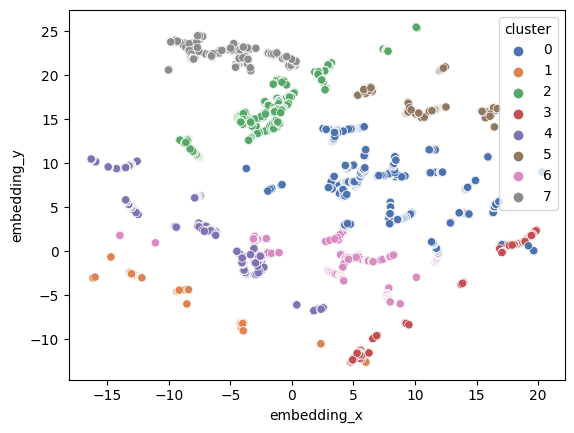

In [71]:
sns.scatterplot(data=df9, x='embedding_x', y='embedding_y', hue='cluster', palette='deep')

## 9.2. Cluster profile

In [72]:
# Saindo do espaço de embedding para o espaço de features
df92 = df4[cols_selected].copy()
df92['cluster'] = labels

In [73]:
df92.head()

,customer_id,gross_revenue,recency,qtd_products,frequency,returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,6


In [74]:
## change types
#df92['recency'] = df92['recency'].astype(int)
#df92['qtd_products'] = df92['qtd_products'].astype(int)
#df92['returns'] = df92['returns'].astype(int)

In [75]:
df92.head()

,customer_id,gross_revenue,recency,qtd_products,frequency,returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,6


In [76]:
# Number of customers
df_clusters = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Number of customers (%)
df_clusters['% customer_id'] = (df_clusters[['customer_id']] / df_clusters[['customer_id']].sum()) * 100

# Average gross revenue
aux1 = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

# % Gross revenue
aux2 = (df92[['cluster', 'gross_revenue']].groupby('cluster').sum() / df92['gross_revenue'].sum()).reset_index().rename(columns={'gross_revenue': '% gross_revenue'})

# Average recency
aux3 = df92[['recency', 'cluster']].groupby('cluster').mean().reset_index()

# Average invoice no
#aux4 = df92[['qtd_invoices', 'cluster']].groupby('cluster').mean().reset_index()

# Average qtd_products
aux4 = df92[['qtd_products', 'cluster']].groupby('cluster').mean().reset_index()

# Average frequency
aux5 = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()

# Average returns
aux6 = df92[['returns', 'cluster']].groupby('cluster').mean().reset_index()

In [77]:
df_clusters = pd.merge(df_clusters, aux1, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux2, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux3, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux4, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux5, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux6, on='cluster', how='left')

In [78]:
df_clusters_sorted = df_clusters.sort_values(by=['gross_revenue'], ascending=False).reset_index(drop=True)
df_clusters_sorted

,cluster,customer_id,% customer_id,gross_revenue,% gross_revenue,recency,qtd_products,frequency,returns
0,7,792,13.909378,6762.402500,0.530044,51.736111,347.097222,0.225605,194.472222
1,2,1024,17.983843,2255.135439,0.228538,115.767578,138.197266,0.567404,2.728516
2,5,498,8.746048,1333.253635,0.065709,105.805221,71.152610,0.518504,10.586345
3,3,445,7.815244,1162.194787,0.051183,65.143820,44.022472,0.029035,8.791011
4,4,726,12.750263,629.780152,0.045249,98.304408,20.877410,0.292693,3.376033
5,1,283,4.970144,609.948269,0.017083,180.106007,32.098940,0.483519,7.385159
6,0,1280,22.479803,356.101930,0.045110,139.702344,20.565625,0.950787,3.021094
7,6,646,11.345276,267.227043,0.017084,191.061920,8.352941,0.806859,5.236842


In [79]:
insider_cluster_no = df_clusters_sorted.loc[0, 'cluster']

In [80]:
insider_cluster_no

7

| Cluster | Nome |
|:-------:|------|
| 7 | Insiders |
| 2 | Spend more |
| 5 | More products |
| 3 | Even more spending |
| 4 | Almost there |
| 1 | Low buy and return |
| 0 | No more return |
| 6 | Lazzy boys |

---

**Cluster 3 (candidatos à insiders)**:
- Número de customers: 468 (15,78%)
- Faturamento médio: US$ 8.835,98
- Recência média: 21,45
- Média de compras: 424,12
- Frequência de compra: 0,065 produtos/dia
---

# 10. Exploratory Data Analisys

In [81]:
df10 = df92.copy()
df10.head()

,customer_id,gross_revenue,recency,qtd_products,frequency,returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,6


## 10.1. MindMap de hipóteses

1. Fenômeno
2. Entidades (customer, location, finance, family)
3. Características da entidade --> Ex.: customer=(nome, idade, salário, escolaridade)

## 10.2. Hipóteses de negócio

![Clusterização de clientes de um e-commerce.png](<attachment:Clusterização de clientes de um e-commerce.png>)
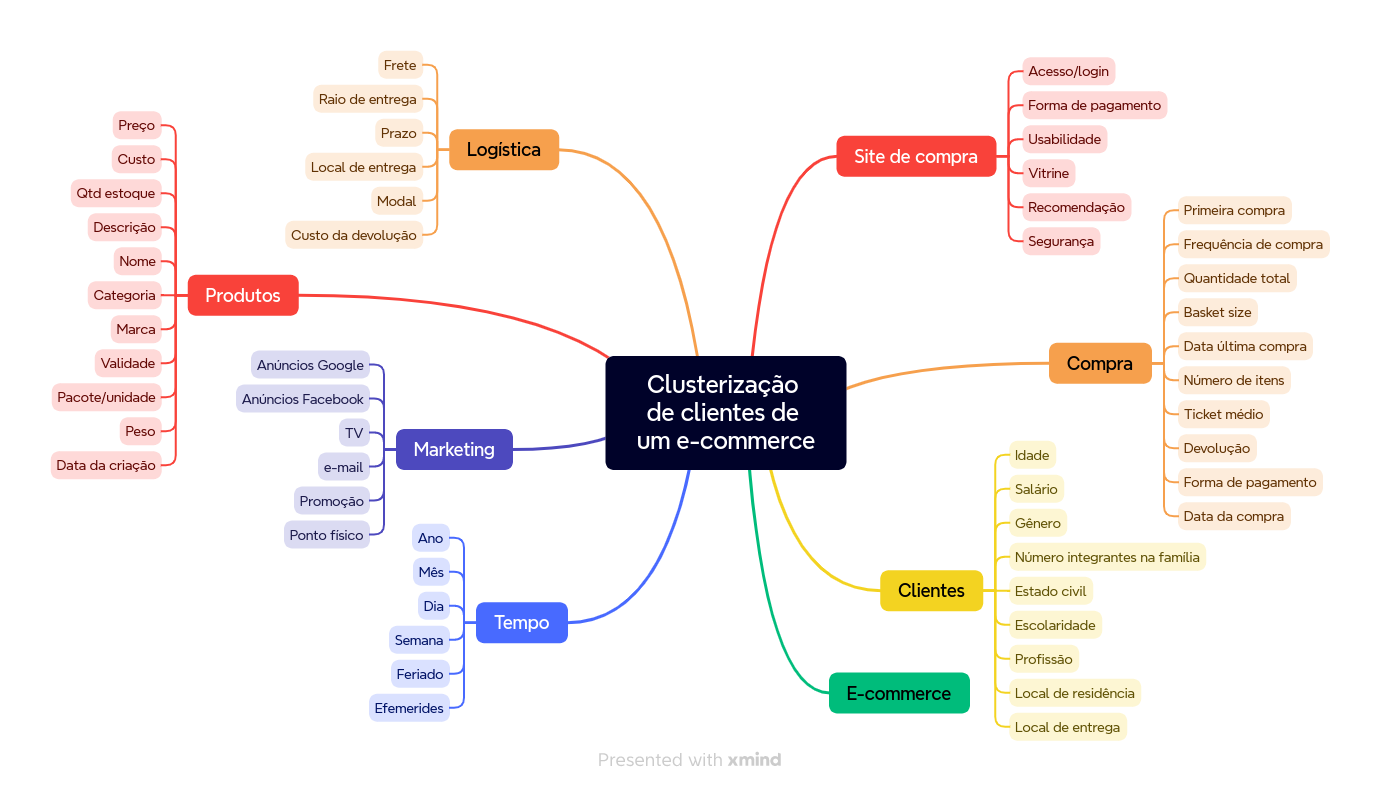

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

Cluster | Variável para testar | Base comparação

### 10.2.1 Hipótese Compra

1. Os clientes do cluster Insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster Insiders possuem um ticket médio de 10% acima do cluster Spend more.
3. Os clientes do cluster Insiders possuem um basket size médio acime de 5 produtos.
4. **Os clientes do cluster Insiders representam mais de 10% do volume (produtos) total de compras.**
5. **Os clientes do cluster Insiders representam mais de 10% do volume (faturamento) total de compras.**
6. **Os clientes do cluster Insiders tem a quantidade média de devoluções abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster Insiders é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do GMV pelos clientes do cluster Insiders.**

### H1: Os clientes do cluster Insiders representam mais de 10% do volume (produtos) total de compras
**Verdadeiro:** O cluster Insiders representa 54,49% do total de compras.

In [82]:
total = df10['qtd_products'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['qtd_products'].sum()
print(f'O volume de produtos dos insiders representa {(insiders/total)*100:.2f}% do total de compras.')

O volume de produtos dos insiders representa 52.12% do total de compras.


### H2: Os clientes do cluster Insiders representam mais de 10% do volume (faturamento) total de compras
**Verdadeiro:** O cluster Insiders representa 51,74% do total de compras.

In [83]:
total = df10['gross_revenue'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].sum()
print(f'O volume de receita com os insiders representa {(insiders/total)*100:.2f}% do total de compras.')

O volume de receita com os insiders representa 53.00% do total de compras.


### H3: Os clientes do cluster Insiders tem a quantidade média de devoluções abaixo da média da base total de clientes.
**Falsa:** A média de devoluções do cluster Insiders é 428.60% maior do que a média total.

In [84]:
total_avg_return = df10['returns'].mean()
insiders_avg_return = df10.query('cluster == @insider_cluster_no')['returns'].mean()
print(f'Média total: {total_avg_return:.2f}')
print(f'Média dos Insiders: {insiders_avg_return:.2f}')
print(f'A média de devoluções do cluster Insiders é {(insiders_avg_return/total_avg_return)*100:.2f}% maior do que a média total.')

Média total: 31.22
Média dos Insiders: 194.47
A média de devoluções do cluster Insiders é 622.82% maior do que a média total.


### H4: A mediana do faturamento dos clientes do cluster Insiders é 10% maior do que a mediana do faturamento geral.
**Verdadeira:** A mediana dos Insiders é 275,99% maior do que a mediana total.

In [85]:
# mediana de gmv Insiders
median_gmv_insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].median()

# mediana de gmv total
median_gmv_total = df10['gross_revenue'].median()

diff_median = ((median_gmv_insiders - median_gmv_total) / median_gmv_total) * 100

print(f'{diff_median:.2f}%')

454.71%


### H5: O percentil do GMV pelos clientes do cluster Insiders está concentrada no quartil 3.
**Falsa:** O faturamento está concentrado no quartil 1

In [86]:
np.percentile(df10.query('cluster == @insider_cluster_no')['gross_revenue'], q=0.1)

461.93

In [87]:
np.percentile(df10.query('cluster == @insider_cluster_no')['gross_revenue'], q=0.9)

707.82478

<Axes: xlabel='gross_revenue'>

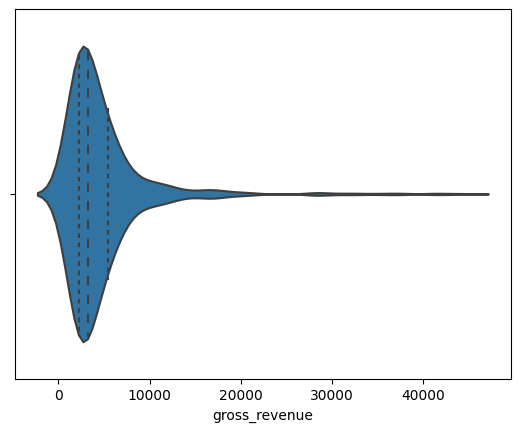

In [88]:
sns.violinplot(x=df10.query('cluster == @insider_cluster_no & gross_revenue < 50000')['gross_revenue'], inner='quart')

### 10.2.2. Hipótese Cliente

1. 60% dos clientes do cluster Insiders são solteiros.
2. 10% dos clientes do cluster Insiders estão na faixa de 24-35 anos.
3. 40% dos clientes do cluster Insiders possuem localidade de entrega dentro de um raio de 50 km.
4. 5% dos clientes do cluster Insiders recebem mais de US$ 100k anual.
5. 90% dos clientes do cluster Insiders possuem ensino superior completo.

### 10.2.3. Hipótese Produto

1. 30% dos produtos em pacotes grandes são comprados pelos clientes do cluster Insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior do que a mediana de todos os preços dos produtos
3. O percentil do preço dos produtos comprados pelos clientes do cluster Insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior do que o peso médio dos demais clusters.
5. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor do que 15 dias.

### 10.2.4. Perguntas de negócio

#### 1. Quem são as pessoas elegíveis para participar do programa?

In [89]:
df10.query('cluster == @insider_cluster_no')['customer_id'].head()

0    17850
1    13047
2    12583
5    15291
6    14688
Name: customer_id, dtype: int64

#### 2. Quantos clientes farão parte do grupo?

In [90]:
df10.query('cluster == @insider_cluster_no')['customer_id'].nunique()

792

#### 3. Quais as principais características desses clientes?

**Cluster Insiders**:
- Número de customers: 468 (15,78%)
- Faturamento médio: US$ 8.835,98
- Recência média: 21,45
- Média de compras: 424,12
- Frequência de compra: 0,065 produtos/dia
---

#### 4. Qual a porcentagem de contribuição dos insiders no faturamento?

In [91]:
total = df10['gross_revenue'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].sum()
print(f'O volume de receita com os insiders representa {(insiders/total)*100:.2f}% do total de compras.')

O volume de receita com os insiders representa 53.00% do total de compras.


#### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

#### 6. Quais as condições para uma pessoa ser elegível ao grupo?

#### 7. Quais as condições para uma pessoa ser removida do grupo?

#### 8. Qual a garantia que o programa é melhor que o restante da base?

#### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.3. Priorização das hipóteses

## 10.4. Validação das hipóteses

## 10.5. Quadro de resultados

# 11. Deploy to Production

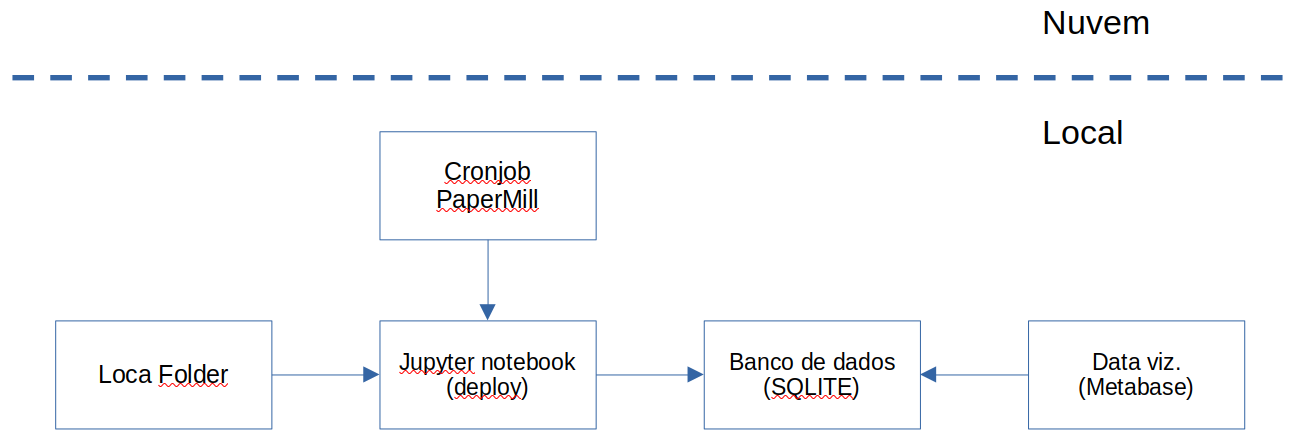

In [92]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency          float64
qtd_products     float64
frequency        float64
returns          float64
cluster            int64
dtype: object

In [93]:
# change types
df92['recency'] = df92['recency'].astype(int)
df92['qtd_products'] = df92['qtd_products'].astype(int)
df92['returns'] = df92['returns'].astype(int)

In [94]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency            int64
qtd_products       int64
frequency        float64
returns            int64
cluster            int64
dtype: object

## 11.1. Insert into SQLITE

In [106]:
# database connection
conn = create_engine('sqlite:///insiders_db.sqlite')

# drop table --> delete the entire table
query_drop_table = """
    DROP TABLE insiders
"""

# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency         INTEGER,
        qtd_products    INTEGER,
        frequency       REAL,
        returns         INTEGER,
        cluster         INTEGER
    )
"""

conn.execute(query_drop_table)
conn.execute(query_create_table_insiders)

In [107]:
# insert data
#df92.to_sql('insiders', con=conn, if_exists='append', index=False)

5694

In [104]:
## get query
#query_collect = """
#    SELECT *
#    FROM insiders
#"""
#
#df = pd.read_sql_query(query_collect, con=conn)